In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from scipy.stats import mstats
import statsmodels.api as sm
from scipy.stats import boxcox

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
df = pd.read_excel('./florida_2017.xls')
df.columns = ['city', 'population', 'violent_crime', 'murder', 'rape', 'robbery',
       'assault', 'property_crime', 'burglary', 'larceny_theft',
       'motor_vehicle_theft', 'arson']
df.set_index('city', inplace=True)

crime_cols = ['violent_crime', 'murder', 'rape', 'robbery', 
              'assault', 'property_crime', 'burglary', 'larceny_theft', 
              'motor_vehicle_theft', 'arson']

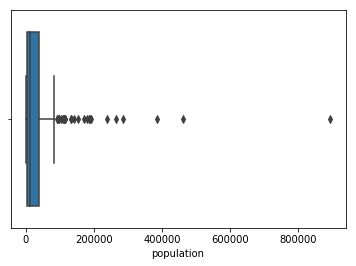

In [3]:
sns.boxplot(df.population)

In [4]:
# so we will want to remove some outliers
df = df[df.population<df.population.quantile(0.9)]

# log population
df["population_log"] = np.log(df.population)
# log1p first adds 1 to x then logs the result
df["property_crime_log"] = np.log1p(df.property_crime)
# square population
df["population_squared"] = df.population**2
df["population_cube_root"] = df.population**(1/3)
# create robbery dummy var
df["has_robbery"] = np.where(df.robbery>0,1,0)
# create a murder category
df["has_murder"] = np.where(df.murder>0, 1, 0)
df["has_assault"] = np.where(df.assault>0, 1, 0)

In [5]:
df.skew()

population              1.351
violent_crime           2.825
murder                  4.326
rape                    2.413
robbery                 3.483
assault                 3.108
property_crime          1.987
burglary                1.883
larceny_theft           1.998
motor_vehicle_theft     2.768
arson                   2.211
population_log         -0.386
property_crime_log     -0.585
population_squared      2.300
population_cube_root    0.379
has_robbery            -1.509
has_murder              0.548
has_assault            -2.965
dtype: float64

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


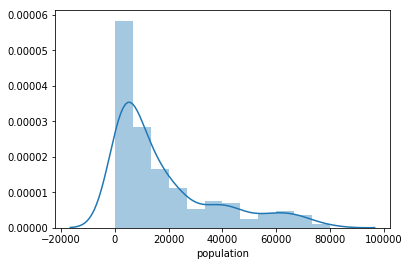

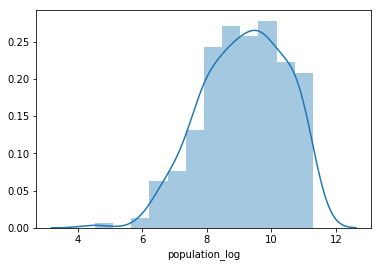

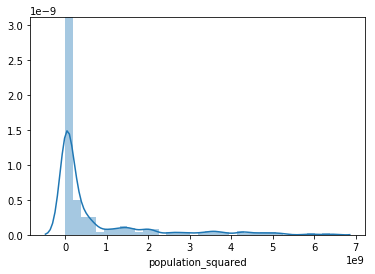

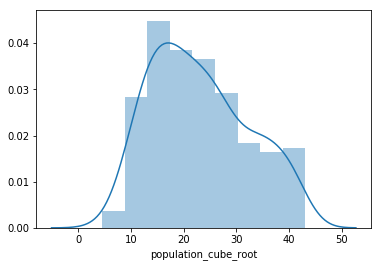

In [6]:
sns.distplot(df.population)
plt.show()
sns.distplot(df.population_log)
plt.show()
sns.distplot(df.population_squared)
plt.show()
sns.distplot(df.population_cube_root)
plt.show()

*Cube root of population looks to be the best to use in place of population.*

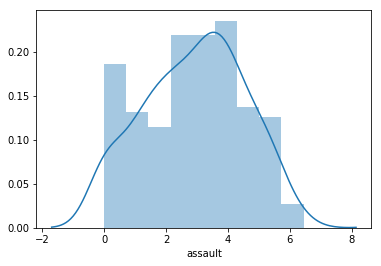

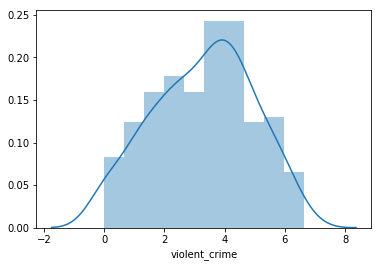

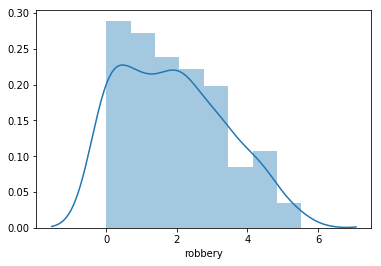

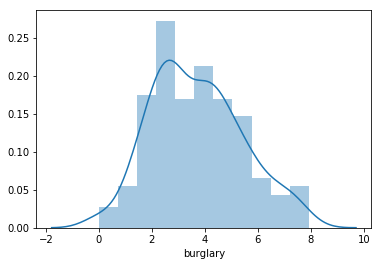

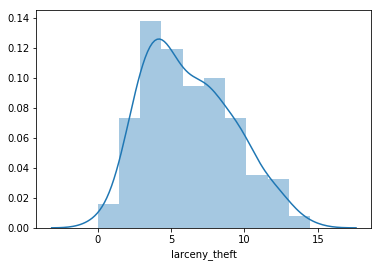

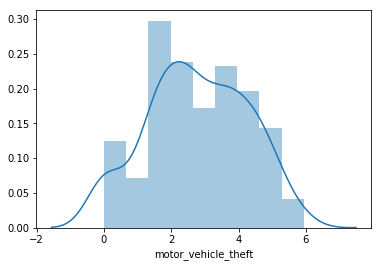

In [7]:
# split into population groups
df["population_low"] = (df.population < 3620.0).astype("int")
df["population_medium"] = (df.population.between(3620.0, 24929.5)).astype("int")
df["population_high"] = (df.population >= 24929.5).astype("int")

sns.distplot(np.log1p(df.assault))
df["assault_log"] = np.log1p(df.assault)
plt.show()
sns.distplot(np.log1p(df.violent_crime))
df["violent_crime_log"] = np.log1p(df.violent_crime)
plt.show()
sns.distplot(np.log1p(df.robbery))
df["robbery_log"] = np.log1p(df.robbery) 
plt.show()
sns.distplot(df.burglary**(1/3))
df["burglary_cube_root"] = df.burglary**(1/3)
plt.show()
sns.distplot(df.larceny_theft**(1/3))
df["larceny_theft_cube_root"] = df.larceny_theft**(1/3)
plt.show()
sns.distplot(np.log1p(df.motor_vehicle_theft))
df["motor_vehicle_theft_log"] = np.log1p(df.motor_vehicle_theft)
plt.show()

# Split

In [8]:
train = df.sample(frac=0.7, random_state=41)
test_cities = list(set(df.index).difference(set(train.index)))
test = df.loc[test_cities,:]
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (178, 27)
Test shape: (77, 27)


# Model

In [9]:
model_vars = ['population_log', 'has_robbery', 
              'population_medium', "population_medium",
              "burglary_cube_root", "assault_log", 
              "larceny_theft_cube_root", 
               "robbery_log", "burglary_cube_root"]

formula1 = "property_crime ~ " + ' + '.join(model_vars)
lm1 = smf.ols(formula=formula1, data=train).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     252.6
Date:                Tue, 11 Dec 2018   Prob (F-statistic):           2.44e-86
Time:                        23:57:03   Log-Likelihood:                -1207.1
No. Observations:                 178   AIC:                             2430.
Df Residuals:                     170   BIC:                             2456.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 344.1708    226.714      1.518      0.131    -103.366     791.708
population_log           -123.1635     34.346     -3.586      0.000    -190.963     -55.364
has_robbery              -284.4694     54.506     -5.219      0.000    -392.065    -176.874
population_medium        -198.5543     35.716     -5.559      0.000    -269.058    -128.050
burglary_cube_root         90.9654     30.772      2.956      0.004      30.221     151.710
assault_log               -52.5566     27.032     -1.944      0.054    -105.918       0.805
larceny_theft_cube_root   215.6666     19.010     11.345      0.000     178.140     253.193
robbery_log                71.6804     32.843      2.183      0.030       6.848     136.513
==============================================================================
Omnibus:                       98.293   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              614.568
Skew:                           2.004   Prob(JB):                    3.53e-134
Kurtosis:                      11.173   Cond. No.                         182.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
model_vars2 = ['population_log', 'has_robbery', 
              'population_medium',
              "robbery_log", "burglary_cube_root",
              "larceny_theft_cube_root", "motor_vehicle_theft_log"]
formula2 = "property_crime_log ~ " + ' + '.join(model_vars2)
lm2 = smf.ols(formula=formula2, data=train).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     property_crime_log   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     876.1
Date:                Tue, 11 Dec 2018   Prob (F-statistic):          8.37e-130
Time:                        23:57:16   Log-Likelihood:                -15.446
No. Observations:                 178   AIC:                             46.89
Df Residuals:                     170   BIC:                             72.35
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.0135      0.289      3.504      0.001       0.443       1.585
population_log              0.1061      0.044      2.432      0.016       0.020       0.192
has_robbery                 0.5123      0.068      7.531      0.000       0.378       0.647
population_medium           0.3367      0.044      7.719      0.000       0.251       0.423
robbery_log                -0.1680      0.038     -4.424      0.000      -0.243      -0.093
burglary_cube_root          0.2229      0.035      6.290      0.000       0.153       0.293
larceny_theft_cube_root     0.3276      0.024     13.410      0.000       0.279       0.376
motor_vehicle_theft_log     0.1081      0.038      2.874      0.005       0.034       0.182
==============================================================================
Omnibus:                       51.131   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.919
Skew:                          -1.191   Prob(JB):                     1.13e-30
Kurtosis:                       6.595   Cond. No.                         187.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Evaluate

In [19]:
predicted1 = lm1.predict(test)
actual1 = test["property_crime"]
residuals1 = actual1 - predicted1

print("MODEL EVALUATION\n--------------------\nr^2: 0.973")
print("\nTRAIN\n--------------------")
print("Mean Residual: {}".format(lm1.resid.mean()))
print("RMSE: {}".format(round(lm1.resid.std()),2))

print("\n\nTEST\n--------------------")
print("Mean Residual: {}".format(residuals1.mean()))
print("RMSE: {}".format(round(residuals1.std()),2))

MODEL EVALUATION
--------------------
r^2: 0.973

TRAIN
--------------------
Mean Residual: -4.017999416329699e-12
RMSE: 214.0


TEST
--------------------
Mean Residual: -19.97054107469807
RMSE: 206.0


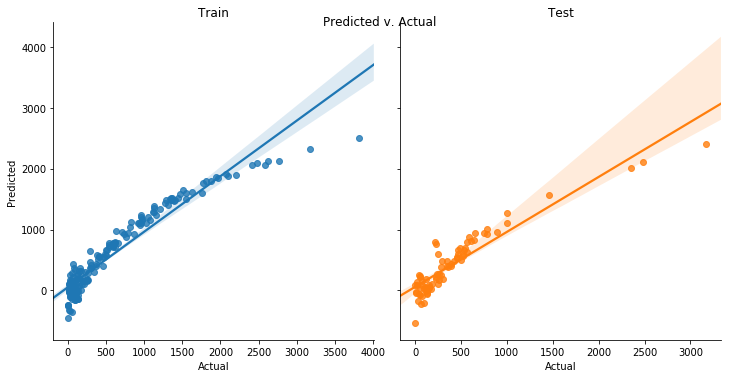

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.tight_layout()
fig.suptitle("Predicted v. Actual")
sns.regplot(train["property_crime"], lm1.fittedvalues, ax=ax1)
ax1.set_title("Train")
sns.despine(ax=ax1)

sns.regplot(actual1, predicted1, ax=ax2)
ax1.set(xlabel="Actual", ylabel="Predicted")
sns.despine(ax=ax2)
ax2.set_xlabel("Actual")
ax2.set_title("Test")
plt.show()

*Remember that for model 2 that we are predicting the log of property crime, so we need to exponentiate the predicted values.*

In [14]:
predicted2 = lm2.predict(test)
actual2 = test["property_crime_log"]
residuals2 = actual2 - predicted2

print("MODEL EVALUATION\n--------------------\nr^2: 0.973")
print("\nTRAIN\n--------------------")
print("Mean Residual: {}".format(np.exp(lm2.resid.mean())))
print("RMSE: {}".format(round(np.exp(lm2.resid.std()),2)))

print("\n\nTEST\n--------------------")
print("Mean Residual: {}".format(np.exp(residuals2.mean())))
print("RMSE: {}".format(round(np.exp(residuals2.std()),2)))

MODEL EVALUATION
--------------------
r^2: 0.973

TRAIN
--------------------
Mean Residual: 1.0000000000000004
RMSE: 1.3


TEST
--------------------
Mean Residual: 1.0210494782229915
RMSE: 1.4


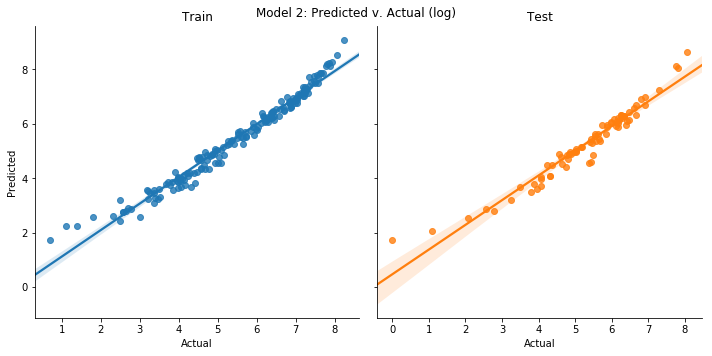

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.suptitle("Model 2: Predicted v. Actual (log)")
sns.regplot(train["property_crime_log"], lm2.fittedvalues, ax=ax1)
ax1.set_title("Train")
sns.despine(ax=ax1)

sns.regplot(actual2, predicted2, ax=ax2)
ax1.set(xlabel="Actual", ylabel="Predicted")
sns.despine(ax=ax2)
ax2.set_xlabel("Actual")
ax2.set_title("Test")
fig.tight_layout()
plt.show()

In [16]:
predicted3 = np.exp(lm2.predict(test))
actual3 = test["property_crime"]
residuals3 = actual3 - predicted3

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


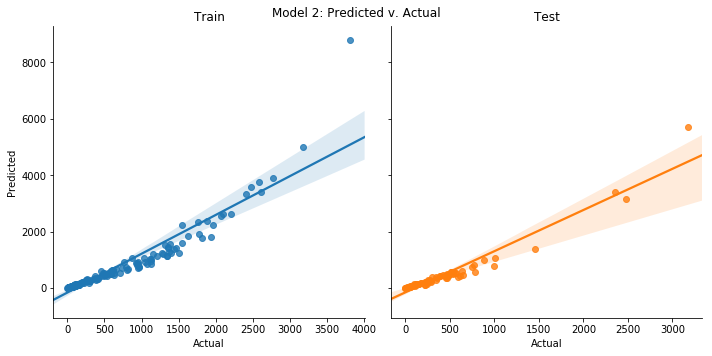

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.suptitle("Model 2: Predicted v. Actual")
sns.regplot(train["property_crime"], np.exp(lm2.fittedvalues), ax=ax1)
ax1.set_title("Train")
sns.despine(ax=ax1)

sns.regplot(actual3, predicted3, ax=ax2)
ax1.set(xlabel="Actual", ylabel="Predicted")
sns.despine(ax=ax2)
ax2.set_xlabel("Actual")
ax2.set_title("Test")
fig.tight_layout()
plt.show()

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


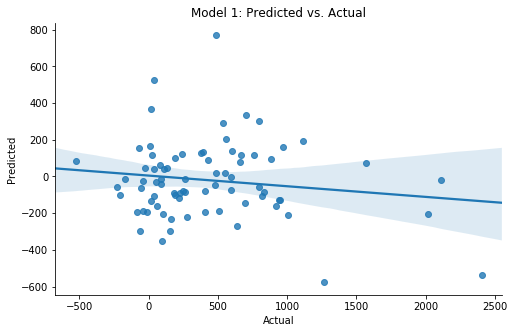

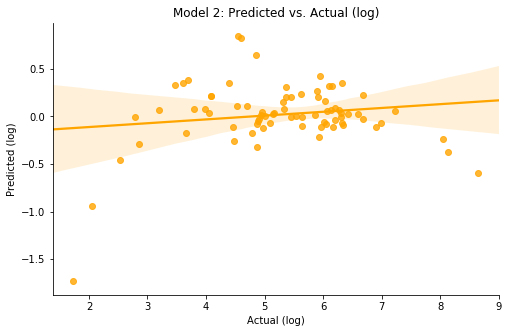

In [54]:
plt.figure(figsize=(8,5))
sns.regplot(predicted1, residuals1, fit_reg = True)
plt.xlabel("Actual")
plt.ylabel("Predicted")
sns.despine()
plt.title("Model 1: Predicted vs. Actual")
plt.show()

plt.figure(figsize=(8,5))
sns.regplot(predicted2, residuals2, fit_reg = True, color="orange")
plt.xlabel("Actual (log)")
plt.ylabel("Predicted (log)")
sns.despine()
plt.title("Model 2: Predicted vs. Actual (log)")
plt.show()

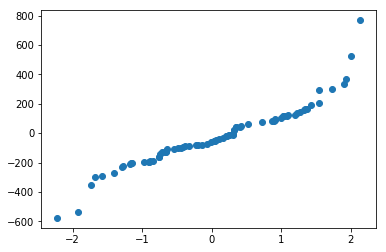

In [31]:
norm = np.random.normal(0,1,len(residuals1))
norm.sort()

residuals1.values.sort()
plt.scatter(norm, residuals1)
plt.show()

# Conclusion
The actual versus predicted plot (for the first model), shows us that the property crime variable is only linear up until a certain point (lets call this the saturation point). A linear model does not make sense for all cities; separate models should be used according to the population.